# Grad Project Analysis Notebook

## Data Sampling and Collection 

The data used for this project is from **Dataset A: Space Exploration** of **Topic 3: Emerging Research and Technologies**, which includes data from reports of outer space exploration focusing on faraway exoplanets. The two data sets I will be using for this project are **kepler_exoplanet_search.csv** ([Source](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=koi)) and **kepler_planetary_system_composite.csv** ([Source](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars)), which are both data sets from the NASA Exoplanet Archive of the NASA Exoplanet Science Institute. (Note: The kepler search dataset that was provided in DataHub is missing many parameters, so I will also be using a suppllemenaty external dataset to fill in the missing information: **koi_composite.csv** - [Source](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative)).

The dataset, **kepler_exoplanet_search.csv**, collected from the Kelper Space Observatory focuses on finding candidate exoplanets that may be habitable. These candidate exoplanets are called Kepler objects of interests. The external dataset I used **koi_composite.csv** includes values for some of the characteristics/parameters of the Kepler objects of interest that are missing in the first dataset. On the other hand, the dataset, **kepler_planetary_system_composite.csv**, contains all the confirmed planets outside of the solar system, including those from the Kepler missions. A bias that may have arisen from the collection of the Kepler exoplanet data was that the Kepler Space Telescope is trained to look in areas where objects of interest or masses may have already been detected or are expected to be detected, so , and also there may be observational bias towards the detection of larger planets.

The goal of the project is to determine which features can be used to create a machine learning model to predict if a CANDIDATE kepler object of interest should be a CONFIRMED exoplanet or if it was a FALSE POSITIVE.

#### Import Libraries

In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Data Cleaning

**Read in Kepler Exoplanet Search Dataset and Kepler Planetary System Composite Dataset**

In [2]:
kep_search = pd.read_csv("data/kepler_exoplanet_search.csv")
koi_comp = pd.read_csv("data/koi_composite.csv")
kep_comp = pd.read_csv("data/kepler_planetary_system_composite.csv")

#### Kepler Exoplanet Search Dataset

- **Granularity:** Each entry represents a kepler object of interest (possible exoplanet) that has been discovered on the Kepler missions
- The dataset includes many invalid entries. Many of the features only include NaN entries.

In [3]:
kep_search.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,11446443,K00001.01,Kepler-1 b,CONFIRMED,Done,2018-08-16,CANDIDATE,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10666592,K00002.01,Kepler-2 b,CONFIRMED,Done,2018-08-16,CANDIDATE,NaN,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10748390,K00003.01,Kepler-3 b,CONFIRMED,Done,2018-08-16,CANDIDATE,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3861595,K00004.01,Kepler-1658 b,CONFIRMED,Done,2018-08-16,CANDIDATE,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8554498,K00005.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will remove all the features that only have NaN entries and create a new dataframe **kep_search_clean**

In [4]:
#function that removes all the columns with only NaN values
def rm_nan_features(df):
    clean_df = pd.DataFrame()
    for column in df.columns:
        if not all(pd.isnull(df[column])):
            clean_df[column] = df[column]
    return clean_df

#remove all columns with only NaN values from the Kepler Exoplanet Search dataset
kep_search_clean = rm_nan_features(kep_search)
kep_search_clean.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag
0,11446443,K00001.01,Kepler-1 b,CONFIRMED,Done,2018-08-16,CANDIDATE,0,0,0,...,286.80847,49.316399,11.338,11.736,11.275,11.168,11.126,10.232,9.920,9.846
1,10666592,K00002.01,Kepler-2 b,CONFIRMED,Done,2018-08-16,CANDIDATE,0,1,0,...,292.24728,47.969521,10.463,10.935,10.490,NaN,NaN,9.555,9.344,9.334
2,10748390,K00003.01,Kepler-3 b,CONFIRMED,Done,2018-08-16,CANDIDATE,0,0,0,...,297.70935,48.080853,9.174,10.665,9.479,NaN,NaN,7.608,7.131,7.009
3,3861595,K00004.01,Kepler-1658 b,CONFIRMED,Done,2018-08-16,CANDIDATE,0,0,0,...,294.35654,38.947380,11.432,11.755,11.354,11.294,11.305,10.475,10.266,10.195
4,8554498,K00005.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0,0,0,...,289.73972,44.647419,11.665,12.085,11.601,11.485,11.458,10.542,10.257,10.213


#### Kepler Object of Interest Composite Dataset

- **Granularity:** Each entry represents a kepler object of interest (possible exoplanet) that has been discovered on the Kepler missions
- This dataset contains data for the information on various characteristics of the Kepler objects of interest that were missing from the provided Kepler Search dataset, such as planet radius, transit duration, transit depth, planet equilibrium temperature, stellar effective temperature, and insolation flux.
- This dataset does not seem to contain invalid entries.

In [5]:
koi_comp[['kepid','koi_prad','koi_insol', 'koi_teq','koi_depth','koi_duration','koi_steff', 'koi_impact']].head()

,kepid,koi_prad,koi_insol,koi_teq,koi_depth,koi_duration,koi_steff,koi_impact
0,10797460,2.26,93.59,793.0,615.8,2.95750,5455.0,0.146
1,10797460,2.83,9.11,443.0,874.8,4.50700,5455.0,0.586
2,10811496,14.60,39.30,638.0,10829.0,1.78220,5853.0,0.969
3,10848459,33.46,891.96,1395.0,8079.2,2.40641,5805.0,1.276
4,10854555,2.75,926.16,1406.0,603.3,1.65450,6031.0,0.701


The data from the **Kepler Object of Interest Composite Dataset** will be merged with **Kepler Exoplanet Search Dataset** by the specific Kepler of Interests to form a new dataframe called **koi_merged**.

In [6]:
koi_merged = kep_search_clean.merge(koi_comp[['kepid','koi_prad','koi_insol', 'koi_teq', 'koi_depth','koi_duration','koi_steff']],
                                    on = ['kepid']).drop_duplicates()
koi_merged.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_prad,koi_insol,koi_teq,koi_depth,koi_duration,koi_steff
0,11446443,K00001.01,Kepler-1 b,CONFIRMED,Done,2018-08-16,CANDIDATE,0,0,0,...,11.126,10.232,9.920,9.846,13.04,761.46,1339.0,14231.0,1.74319,5820.0
1,10666592,K00002.01,Kepler-2 b,CONFIRMED,Done,2018-08-16,CANDIDATE,0,1,0,...,NaN,9.555,9.344,9.334,16.10,4148.92,2048.0,6674.7,3.88864,6440.0
2,10748390,K00003.01,Kepler-3 b,CONFIRMED,Done,2018-08-16,CANDIDATE,0,0,0,...,NaN,7.608,7.131,7.009,4.82,96.67,800.0,4315.8,2.36255,4778.0
3,3861595,K00004.01,Kepler-1658 b,CONFIRMED,Done,2018-08-16,CANDIDATE,0,0,0,...,11.305,10.475,10.266,10.195,12.94,4055.29,2034.0,1298.6,2.63200,6244.0
4,8554498,K00005.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0,0,0,...,11.458,10.542,10.257,10.213,7.14,1020.05,1441.0,960.8,2.02530,5937.0


**Kepler Planetary System Composite Dataset**

- **Granularity:** Each entry in the dataset contains information on a confirmed exoplanet from outside of our solar system
- This dataset also contains several features/columns with invalid values (all NaNs). 

In [7]:
kep_comp.head()

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,sy_snum,sy_pnum,...,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,sy_kepmag_reflink,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,2,1,...,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,2,1,2,0,0,0
1,2,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,...,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,1,0,0,0
2,3,14 And b,14 And,b,HD 221345,HIP 116076,TIC 333225860,Gaia DR2 1920113512486282240,1,1,...,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,1,0,0,0
3,4,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,1,1,...,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,4,1,0,0
4,5,16 Cyg B b,16 Cyg B,b,HD 186427,HIP 96901,TIC 27533327,Gaia DR2 2135550755683407232,3,1,...,6.095,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,5,1,4,3,0,0


For this dataset, we will also remove all the features that only have NaN entries and create a new dataframe **kep_comp_clean**.

In [8]:
kep_comp_clean = rm_nan_features(kep_comp)
kep_comp_clean.head()

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,sy_snum,sy_pnum,...,sy_tmagerr2,sy_tmag_reflink,sy_kepmag,sy_kepmag_reflink,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,2,1,...,-0.0071,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,2,1,2,0,0,0
1,2,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,...,-0.0075,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,1,0,0,0
2,3,14 And b,14 And,b,HD 221345,HIP 116076,TIC 333225860,Gaia DR2 1920113512486282240,1,1,...,-0.0073,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,1,0,0,0
3,4,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,1,1,...,-0.0060,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0,1,4,1,0,0
4,5,16 Cyg B b,16 Cyg B,b,HD 186427,HIP 96901,TIC 27533327,Gaia DR2 2135550755683407232,3,1,...,-0.0060,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,6.095,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,5,1,4,3,0,0


## Exploratory Data Analysis

Because we are interested in using both the dataset on Kepler objects of interest and the Kepler Planetary System Composite Dataset, we need to find the features that both have in common:

- Finding common columns(features) between both of the datasets.
- Explore the datasets to see which features are useable

Through looking at our dataset, we find that these are the features both datasets have in common:

- Planet Radius 
- Planetary Insolation
- Equilibrium Temperature 
- Transit Depth
- Transit Duration
- Stellar Effective Temperature
- Declination Angle
- Ascension Angle


After going through the datasets, we find that the features that we would be able to use from the **Kepler Exoplanet Search Dataset** are **koi_prad**, **koi_period**, **koi_insol**, **koi_teq**, **koi_depth**, **koi_duration**, **koi_steff**, **dec,** and **ra** in addition to identification like name(**kepler_name**), and the objects disposition (**koi_disposition**) which tells whether it is a Candidate, Confirmed, or False Positive. 

The corresponding features from the **Kepler Planetary System Composite Dataset** are **pl_name, pl_rade, pl_orbper, pl_insol, pl_eqt, pl_trandep, pl_trandur, st_teff, dec,** and **ra**. Because all of the planets in this dataset are already confirmed to be planets, we need to add a column for **disposition** before merging the two datasets together


In [9]:
koi_merged.columns

Index(['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat',
       'koi_vet_date', 'koi_pdisposition', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov', 'koi_period',
       'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_time0', 'koi_time0_err1', 'koi_time0_err2',
       'koi_parm_prov', 'koi_count', 'koi_tce_delivname', 'koi_datalink_dvr',
       'ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_imag',
       'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag', 'koi_prad', 'koi_insol',
       'koi_teq', 'koi_depth', 'koi_duration', 'koi_steff'],
      dtype='object')

In [10]:
kep_comp_clean.columns

Index(['rowid', 'pl_name', 'hostname', 'pl_letter', 'hd_name', 'hip_name',
       'tic_id', 'gaia_id', 'sy_snum', 'sy_pnum',
       ...
       'sy_tmagerr2', 'sy_tmag_reflink', 'sy_kepmag', 'sy_kepmag_reflink',
       'pl_nnotes', 'st_nphot', 'st_nrvc', 'st_nspec', 'pl_nespec',
       'pl_ntranspec'],
      dtype='object', length=311)

### Combine the two datasets

1. Add disposition column to the **Kepler Planetary Systems Composite** Dataset
2. Keep only the features present in both datasets
3. Rename the features in the **koi_merged** dataframe so that they are consistent with the feature names in the **kep_comp_clean** dataframe
4. Combine the dataframes into one
5. Remove duplicate entries

In [11]:
#add a column for the disposition to the Kepler Planetary Systems Composit Dataset
kep_comp_clean["disposition"] = "CONFIRMED"

#Features to keep that are in both data frames
koi_ft = ['koi_disposition', 'kepler_name','koi_prad', 'koi_period', 'koi_insol', 'koi_teq', 'koi_depth', 'koi_duration', 'koi_steff', 'ra', 'dec']
comp_ft = ['disposition','pl_name', 'pl_rade', 'pl_orbper', 'pl_insol', 'pl_eqt', 'pl_trandep', 'pl_trandur', 'st_teff', 'ra', 'dec']

koi_merged_short = koi_merged[koi_ft]
kep_comp_short = kep_comp_clean[comp_ft]

#Rename the columns in the koi_merged dataframe to match the columns in the kep_comp_clean dataframe
koi_merged_short = koi_merged_short.rename(columns={"koi_disposition": "disposition", 
                                                    "kepler_name": "pl_name", 
                                                    "koi_prad": "pl_rade",
                                                    "koi_period": "pl_orbper",
                                                    "koi_insol": "pl_insol",
                                                    "koi_teq": "pl_eqt",
                                                    "koi_depth": "pl_trandep",
                                                    "koi_duration": "pl_trandur",
                                                    "koi_steff": "st_teff"})

#Concatonate the two dataframes together
kep_exo = pd.concat([koi_merged_short, kep_comp_short]).drop_duplicates().reset_index()
kep_exo = kep_exo.drop("pl_name", axis = 1)

#Transformations on different features
kep_exo["log_orbper"] = np.log(kep_exo["pl_orbper"])
kep_exo["log_radius"] = np.log(kep_exo["pl_rade"])
kep_exo["log_trandep"] = np.log(kep_exo["pl_trandep"])
kep_exo["log_trandur"] = np.log(kep_exo["pl_trandur"])
kep_exo["log_eqt"] = np.log(kep_exo["pl_eqt"])
kep_exo["log_steff"] = np.log(kep_exo["st_teff"])

#Remove rows with NaN or infinite, which are invalid values
kep_exo = kep_exo.replace([np.inf, -np.inf], np.nan)
kep_exo = kep_exo.dropna()
kep_exo.head()

,index,disposition,pl_rade,pl_orbper,pl_insol,pl_eqt,pl_trandep,pl_trandur,st_teff,ra,dec,log_orbper,log_radius,log_trandep,log_trandur,log_eqt,log_steff
0,0,CONFIRMED,13.04,2.470613,761.46,1339.0,14231.0,1.74319,5820.0,286.80847,49.316399,0.904466,2.568022,9.563178,0.555717,7.199678,8.669056
1,1,CONFIRMED,16.10,2.204735,4148.92,2048.0,6674.7,3.88864,6440.0,292.24728,47.969521,0.790608,2.778819,8.806080,1.358059,7.624619,8.770284
2,2,CONFIRMED,4.82,4.887803,96.67,800.0,4315.8,2.36255,4778.0,297.70935,48.080853,1.586743,1.572774,8.370038,0.859742,6.684612,8.471777
3,3,CONFIRMED,12.94,3.849372,4055.29,2034.0,1298.6,2.63200,6244.0,294.35654,38.947380,1.347910,2.560323,7.169042,0.967744,7.617760,8.739376
4,4,CANDIDATE,7.14,4.780328,1020.05,1441.0,960.8,2.02530,5937.0,289.73972,44.647419,1.564509,1.965713,6.867766,0.705718,7.273093,8.688959


### Separate Test Data from Training Data

The test dataset I will be using for this project is made up of all the CANDIDATE kepler exoplanets that have not yet been confirmed as a planet or as a false positive. The training data is made up of the training and validation data tha have been CONFIRMED or noted as FALSE POSITIVE.

In the training data, a column **planet** will be added. Entries with a **disposition** of CONFIRMED should have the value 1 in the **planet** column and entries with a FALSE POSITIVE **disposition** should have the value 0 under the **planet** column.

In [12]:
test = kep_exo[kep_exo['disposition'] == "CANDIDATE"]
train_val = kep_exo[kep_exo['disposition'] != "CANDIDATE"] 
train_val['planet'] = (train_val['disposition'] == 'CONFIRMED').astype(int)
train_val.head()
test.head()

,index,disposition,pl_rade,pl_orbper,pl_insol,pl_eqt,pl_trandep,pl_trandur,st_teff,ra,dec,log_orbper,log_radius,log_trandep,log_trandur,log_eqt,log_steff
4,4,CANDIDATE,7.14,4.780328,1020.05,1441.0,960.8,2.0253,5937.0,289.73972,44.647419,1.564509,1.965713,6.867766,0.705718,7.273093,8.688959
57,57,CANDIDATE,10.35,1.951082,3822.26,2005.0,1151.8,1.6975,5302.0,296.51059,42.547440,0.668384,2.336987,7.049081,0.529157,7.603399,8.575839
92,92,CANDIDATE,10.16,105.881767,29.64,595.0,1556.3,18.0440,5903.0,291.49722,42.728481,4.662323,2.318458,7.350066,2.892813,6.388561,8.683216
93,93,CANDIDATE,10.33,77.479470,86.59,778.0,1237.0,10.1151,6711.0,293.54199,46.822140,4.350013,2.335052,7.120444,2.314029,6.656727,8.811503
94,94,CANDIDATE,96.08,9.250573,3530.57,1966.0,1039.5,3.6373,8133.0,300.53757,46.104340,2.224685,4.565181,6.946495,1.291242,7.583756,9.003685


### Visualizations

The first histogram shows the proportions of CONFIRMED, CANDIDATE, and FALSE POSITIVE exoplanets in the original **Kepler Exoplanet Search** dataset.  

The second histogram shows the proportions of CONFIRMED and FALSE POSITIVE exoplanets in the training dataset.


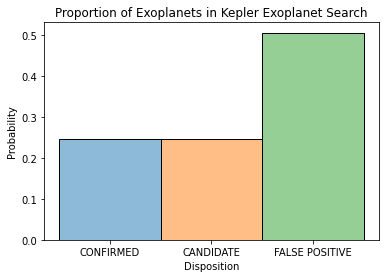

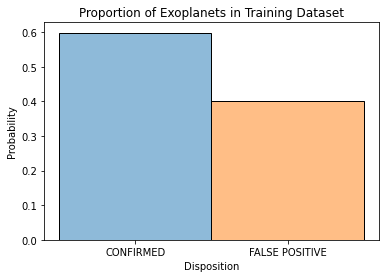

In [71]:
sns.histplot(data = kep_search, x = 'koi_disposition', hue = 'koi_disposition', stat = 'probability', legend = False)
plt.title('Proportion of Exoplanets in Kepler Exoplanet Search')
plt.xlabel('Disposition')
plt.savefig('figures/barchart_exosearch.png')
plt.show();

sns.histplot(data = train_val, x = 'disposition', hue = 'disposition', stat = 'probability', legend = False)
plt.title('Proportion of Exoplanets in Training Dataset')
plt.xlabel('Disposition')
plt.savefig('figures/barchart_training.png')
plt.show();


The following histogram shows the count of the CONFIRMED Kepler Exoplanets in the Kepler Planetary System Composite Dataset. These are the entries that overlap in the two data sets.

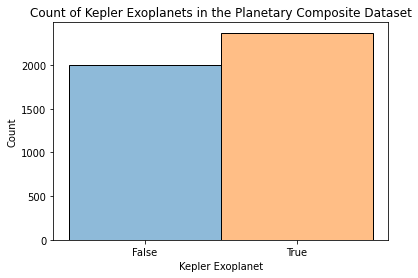

In [78]:
kep_comp['Kepler'] = kep_comp['pl_name'].str.contains('Kepler').astype(str)
sns.histplot(data = kep_comp, x = 'Kepler', hue = 'Kepler', legend = False)
plt.title('Count of Kepler Exoplanets in the Planetary System Composite Dataset')
plt.xlabel('Kepler Exoplanet')
plt.savefig('figures/barchart_propkepler.png')
plt.show();

The correlation heatmap explores if there are any preliminary relationships between the features.

- The features ra and dec seem to be highly correlated, so only one of them needs to be kept as a feature
- In addition, pl_eqt and st_teff; pl_eqt and pl_insol; and pl_trandur and pl_orbper seem to have some level of correlation

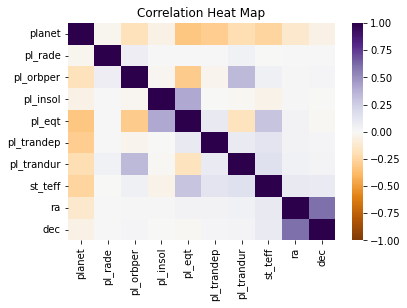

In [48]:
sns.heatmap(train_val[['planet', 'pl_rade', 'pl_orbper', 'pl_insol', 
                      'pl_eqt', 'pl_trandep', 'pl_trandur', 'st_teff', 'ra', 'dec']].corr(), 
            vmin=-1, vmax=1, cmap='PuOr')
plt.title("Correlation Heat Map")
plt.savefig('figures/corr_heatmap.png')
plt.show();

Many of the features need log transformations. After transforming various features with a log transformations, the following jointplots were made to explore the differences in distribution of the features between CONFIRMED and FALSE POSITIVE objects.

While some areas overlap on the plots, there are clear differences in the distributions of log transformed transit depth, log transformed orbital period, log transformed radius, and the equilibrium temperature between CONFIRMED and FALSE POSITIVE kepler objects, so these features may be useful in classifying the Kepler objects of interest.

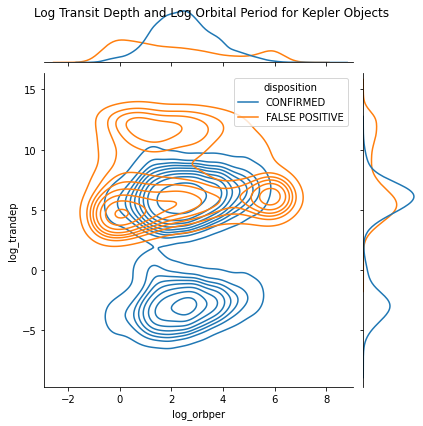

In [15]:
sns.jointplot(data = train_val, x = "log_orbper", y = "log_trandep", hue = "disposition", kind = 'kde')
plt.suptitle("Log Transit Depth and Log Orbital Period for Kepler Objects")
plt.savefig('figures/kdeplot_logtrandep_logorbper.png')
plt.show();

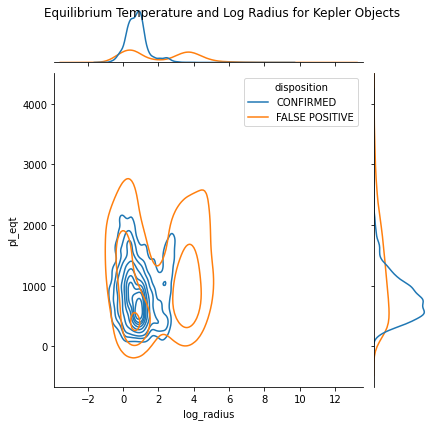

In [16]:
sns.jointplot(data = train_val, x = 'log_radius', y ="pl_eqt",  hue = "disposition", kind = "kde")
plt.suptitle("Equilibrium Temperature and Log Radius for Kepler Objects")
plt.ylim(top = 4500)
plt.savefig('figures/kdeplot_logradius_eqt.png')
plt.show();

For the features Transit Duration (and log transit duration), Declination angle, and Ascension angle, the distribution for CONFIRMED and FALSE POSITIVE exoplanets almost completely overlapped, so those features would not be of much use to the model.

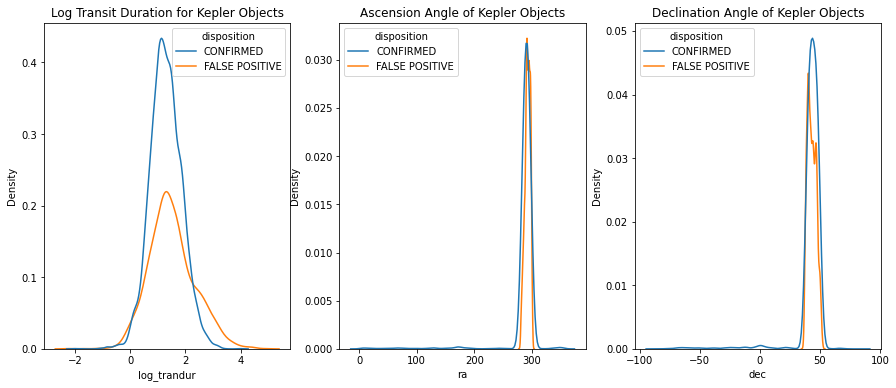

In [17]:
fig, axs = plt.subplots(figsize=(15,6), ncols=3, nrows=1)
plot1 = sns.kdeplot(data = train_val, x = "log_trandur", hue = "disposition", ax = axs[0])
plot1.set(title = 'Log Transit Duration for Kepler Objects')

plot2 = sns.kdeplot(data = train_val, x = "ra", hue = "disposition", ax = axs[1])
plot2.set(title= 'Ascension Angle of Kepler Objects')

plot3 = sns.kdeplot(data = train_val, x = "dec", hue = "disposition", ax = axs[2])
plot3.set(title = 'Declination Angle of Kepler Objects')

plt.savefig('figures/kdeplot_unused_features.png')
plt.show()

After exploring the data through EDA and visualizations, the features we will be using for the model are log radius, log orbital period, equilibrium temperature, and log transit depth.

In [18]:
features = ['log_radius', 'log_orbper', 'log_trandep', 'pl_eqt']


## Data Modeling

### Logistic Regression Model

The machine learning model that will be used as the baseline model is the **logistic regression model**. The logistic regression model will be used because the problem that is being investigated in this project is a binary classification problem. We are trying to find a way to distinguish/classify candidate exoplanets as either CONFIRMED (1) exoplanets, or FALSE POSITIVE (0) exoplanets.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Split the data into separate Training and Validation sets

I will be using 90% of the data as training data and 10% of the data as validation data. These datasets will be used the cross-validation of my model, and that cross validating will check for overfitting in the model.

In [20]:
train, val = train_test_split(train_val[['planet', 'log_radius', 'log_orbper', 'pl_trandep', 'pl_eqt', 'log_eqt', 'log_trandep']], test_size = 0.1, random_state = 42)

x_train = train[features]
y_train = np.array(train['planet'])

x_val = val[features]
y_val = np.array(val['planet'])

x_train[:5], y_train[:5]


(       log_radius  log_orbper  log_trandep  pl_eqt
 6387     0.285179    1.607125     5.267343  1055.0
 16665    0.262364    1.272032    -4.621300  1407.0
 9680    -0.150823   -0.501608     4.622027  2120.0
 17531    0.352767   -0.806141    -3.540459  2480.0
 1570     0.488580    1.308810     5.664002  1050.0,
 array([0, 1, 0, 1, 1]))

### Create the Logistic Regression Model

In [21]:
model = LogisticRegression(solver = 'lbfgs')
model.fit(x_train, y_train)
train_predicts = model.predict(x_train)

val_predicts = model.predict(x_val)


### ROC Curve
ROC Curve for training data using the Logistic Regression. Shows tradeoff for false positives and false negatives at various cutoffs. Quite a high proportion of false positives is needed to capture all the true positives

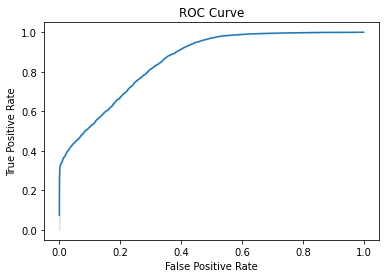

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train, model.predict_proba(x_train)[:, 1])

fig = sns.lineplot(x=fpr, y = tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.savefig('figures/roc_curve.png')
plt.show();

### Confusion Matrix for Logistic Model
Confusion Matrix for the training data using the Logistic Model. There is a low false negative rate but quite a high false positive rate.

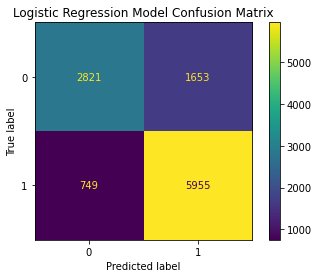

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_train, train_predicts)
cm_disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat)
cm_disp.plot()
plt.title("Logistic Regression Model Confusion Matrix")
plt.savefig('figures/confusion_matrix.png')
plt.show();

### Second Model Using Decision Tree Model

In order to improve the model used to predict the Kepler objects of interest, I will be making a second model, which is this time a decision tree model. The decision tree model is also a supervised machine learning model used for classification. 

In [35]:
from sklearn import tree
model_tree = tree.DecisionTreeClassifier(min_samples_leaf=5)
model_tree.fit(x_train, y_train)

tree_trainpredicts = model_tree.predict(x_train)
tree_valpredicts = model_tree.predict(x_val)

### Confusion Matrix for Decision Tree Model

Confusion Matrix for the training data using the Decision Tree Model. The false negative and false positive rates are much lower in the decision tree model compared to the logistic regression model.

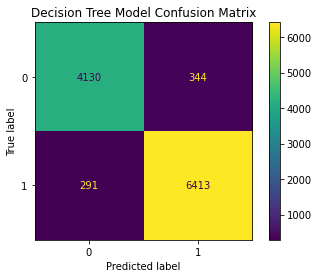

In [38]:
conf_mat_tree = confusion_matrix(y_train, tree_trainpredicts)
cm_disp_tree = ConfusionMatrixDisplay(confusion_matrix = conf_mat_tree)
cm_disp_tree.plot()
plt.title("Decision Tree Model Confusion Matrix")
plt.savefig('figures/confusion_matrix_decisiontree.png')
plt.show();

### Evaluation of Models
- Comparison of Accuracy, Precision, and Recall of the Logistic Regression and Decision Tree Models
- Comparison of Binary Error and Cross-Validation Error of the Logistic Regression and Decision Tree Models

#### Training Data Accuracy, Precision, Recall

In [41]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

### For Logistic Regression Model
training_accuracy = model.score(x_train, y_train)
training_recall = recall_score(y_train, train_predicts)
training_precision = precision_score(y_train, train_predicts)

print("Logistic Regression Training Accuracy:", training_accuracy)
print("Logistic Regression Training Recall:", training_recall)
print("Logistic Regression Training Precision:", training_precision)

print("\n")

### For Decision Tree Model
tree_training_accuracy = model_tree.score(x_train, y_train)
tree_training_recall = recall_score(y_train, tree_trainpredicts)
tree_training_precision = precision_score(y_train, tree_trainpredicts)

print("Decision Tree Training Accuracy:", tree_training_accuracy)
print("Decision Tree Training Recall:", tree_training_recall)
print("Decision Tree Training Precision:", tree_training_precision)


Logistic Regression Training Accuracy: 0.7851136160314904
Logistic Regression Training Recall: 0.8882756563245824
Logistic Regression Training Precision: 0.7827287066246057


Decision Tree Training Accuracy: 0.9431919842547862
Decision Tree Training Recall: 0.9565930787589498
Decision Tree Training Precision: 0.9490898327660204


#### Validation Data Accuracy, Precision, Recall

In [43]:
validation_accuracy = model.score(x_val, y_val)
validation_recall = recall_score(y_val, val_predicts)
validation_precision = precision_score(y_val, val_predicts)

### For Logistic Regression Model
print("Logistic Regression Validation Accuracy:", validation_accuracy)
print("Logistic Regression Validation Recall:", validation_recall)
print("Logistic Regression Validation Precision:", validation_precision)

print("\n")

### For Decision Tree Model
tree_val_accuracy = model_tree.score(x_val, y_val)
tree_val_recall = recall_score(y_val, tree_valpredicts)
tree_val_precision = precision_score(y_val, tree_valpredicts)

print("Decision Tree Validation Accuracy:", tree_val_accuracy)
print("Decision Tree Validation Recall:", tree_val_recall)
print("Decision Tree Validation Precision:", tree_val_precision)


Logistic Regression Validation Accuracy: 0.7793880837359098
Logistic Regression Validation Recall: 0.888283378746594
Logistic Regression Validation Precision: 0.7725118483412322


Decision Tree Validation Accuracy: 0.8727858293075684
Decision Tree Validation Recall: 0.9059945504087193
Decision Tree Validation Precision: 0.8819628647214854


#### Binary Error and Cross Validation Error
The binary error is the proportion of the validation set that the model classifies incorrectly.  
The cross validation error is the error determined by the loss function.

#### Cross Entropy Loss Function
The loss function used for this project is the cross-entropy (log)loss function. The cross-entropy loss function also measures the performance of the model. The cross entropy loss for this model given the data is quite large, meaning that there could be further improvements to the model. Future improvements could be made if more data were collected on different features/characteristics of the kepler objects of interest that are still missing.

In [44]:
from sklearn.metrics import log_loss

### Logistic Regression binary error and cv error
binary_error = np.mean(val_predicts != y_val)
cv_error = log_loss(y_val, val_predicts) 

print("Logistic Regression Binary Error:", binary_error)
print("Logistic Regression Cross Validation Error:", cv_error)

print("\n")

### Decision Tree binary error and cv error
tree_binary_error = np.mean(tree_valpredicts != y_val)
tree_cv_error = log_loss(y_val, tree_valpredicts) 

print("Decision Tree Binary Error:", tree_binary_error)
print("Decision Tree Cross Validation Error:", tree_cv_error)

Logistic Regression Binary Error: 0.22061191626409019
Logistic Regression Cross Validation Error: 7.619789255162742


Decision Tree Binary Error: 0.12721417069243157
Decision Tree Cross Validation Error: 4.393879093854409


The Logistic Regression Model was my baseline model, and I improved the model by switching it to a Decision Tree Model. Overall, the Decision Tree model performed better compared to the Logistic Regression Model for classifying whether the Kepler Objects of Interest should be classified as CONFIRMED or FALSE POSITIVE. The Decision Tree Model had higher Accuracy, Recall and Precision as well as lower binary error and cross validation error when compared to the Logistic Regression Model.

For both of the models I attempted to reduce variance by using regularization. L2 regularization was applied to the features in order to simplify the features and model so that variance is reduced. From a bias-variance tradeoff standpoint, the reduction in variance increased accuracy but also increases bias and error for the model. I checked for overfitting of the models through the use of cross validation, and comparing the predictions and results of the model when applied to training set and the validation set. In addition, for the Decision Tree Model I alleviated the overfitting problem by increasing the parameter min_samples_leaf to 5 when building the model so that the model can learn from more samples of the data before it splits, ensuring that multiple samples are used to inform every decision in the tree.

Although the decision tree model already improved upon the logistic regression model, based on the outcome of the model, there is still room for improvement. The model may be able to be further improved if more features related to the objects of interest being exoplanets or not were used. This would mean that searching through other external datasets for features or future collection of more data is needed.

### Applying the Model to the Test (CANDIDATE) Data

#### Prediction of planets from Test Data using Logistic Regression

In [46]:
x_test = test[features]
test_predictions = model.predict(x_test)

test_predict_planet = sum(test_predictions == 1)
test_predict_false = sum(test_predictions == 0)

print("Number of CANDIDATES predicted to be CONFIRMED (Logistic Regression):", test_predict_planet)
print("Number of CANDIDATES predicted to be FALSE POSITIVES (Logistic Regression):", test_predict_false)
print("Proportion of CANDIDATES predicted to be CONFIRMED (Logistic Regression):", test_predict_planet/len(test_predictions))


Number of CANDIDATES predicted to be CONFIRMED (Logistic Regression): 2532
Number of CANDIDATES predicted to be FALSE POSITIVES (Logistic Regression): 650
Proportion of CANDIDATES predicted to be CONFIRMED (Logistic Regression): 0.7957259585166562


#### Prediction of planets from Test Data using Decision Tree

In [47]:
tree_test_predictions = model_tree.predict(x_test)

tree_test_predict_planet = sum(tree_test_predictions == 1)
tree_test_predict_false = sum(tree_test_predictions == 0)

print("Number of CANDIDATES predicted to be CONFIRMED (Decision Tree):", tree_test_predict_planet)
print("Number of CANDIDATES predicted to be FALSE POSITIVES (Decision Tree):", tree_test_predict_false)
print("Proportion of CANDIDATES predicted to be CONFIRMED (Decision Tree):", tree_test_predict_planet/len(tree_test_predictions))


Number of CANDIDATES predicted to be CONFIRMED (Decision Tree): 1841
Number of CANDIDATES predicted to be FALSE POSITIVES (Decision Tree): 1341
Proportion of CANDIDATES predicted to be CONFIRMED (Decision Tree): 0.5785669390320554


Using the Decision Tree Model, there were less Kepler Objects of Interest that were predicted to be CONFIRMED compared to what the Logistic Regression Model predicted. In the Decision Tree model, about 58% of the test data were CONFIRMED, while in the logistic regression model, about 79% were predicted to be confirmed. This result makes sense because of the much higher false positive rate and lower accuracy that the Logistic Regression Model had in comparison to the Decision Tree model.